
## Projections of Ensemble Species Distribution Models: Assessing Climate Change Impacts on a Pair of Symbiotic Species

*How can models of climate change effects on geographic distributions incorporate symbiotic species relationships? What is the best quantification of uncertainty for climate forecasts in Southwestern deserts?*

---

**Author : [Daniel Furman](mailto:dryanfurman@gmail.com)** **|** Harvey Mudd College **|** NSF Award (#1757952)

---

Scripts for reproducing analyses presented at SICB 2021 and [SCCUR 2019](https://drive.google.com/file/d/1Z9HJnW3p1tecLkUbK6zODJH1dMgzz06j/view?usp=sharing) conferences. The notebook is contained within a [GitHub Repository](https://github.com/daniel-furman/ensemble-climate-projections) alongside its accompanying files and data.

### Comparing ML Classifiers with PyCaret and SKlearn
---

**Description for features is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|BioClim12| Annual Precipitation | mm
|BioClim14| Precip Driest Month| mm
|BioClim15| Precip Seasonality (coefficient of variation)| n/a
|BioClim18| Precip Warmest Quarter | mm
|BioClim19| Precip Coldest Quareter| mm
|BioClim3| Isothermality | $^o$C*100
|BioClim6| Min Temp Coldest Month| $^o$C
|BioClim7| Temp Annual Range| $^o$C
|BioClim8| Mean Temp Wettest Quareter | $^o$C
|BioClim9| Mean Temp Driest Quareter | $^o$C

**Description for the target variable is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|Pa| Binary class | 1 (presence) & 0 (background)

---
 
Binary classification is performed with ten BioClim features, five of which are a function of precipitation and five of temperature. The features were decorrelated below a 0.5 correlation threshold through jacknife resample testing. We use PyCaret to train and tune (10-fold cv) our models from a train set that contains 80% of the total data. Raster processing, data extraction, train/test splitting, as well as data piping to .csv and geojson were performed in R.

---

In [107]:
exec(open('ML_sdms_train.py').read())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8464,0.9232,0.8465,0.8486,0.8461,0.6928,0.6950,0.2760
lightgbm,Light Gradient Boosting Machine,0.8376,0.9166,0.8376,0.8411,0.8371,0.6752,0.6787,0.0510
catboost,CatBoost Classifier,0.8366,0.9192,0.8366,0.8399,0.8361,0.6732,0.6765,1.5940
rf,Random Forest Classifier,0.8356,0.9210,0.8357,0.8392,0.8351,0.6712,0.6748,0.2980
xgboost,Extreme Gradient Boosting,0.8346,0.9120,0.8347,0.8384,0.8341,0.6692,0.6730,0.1490
gbc,Gradient Boosting Classifier,0.8227,0.9068,0.8227,0.8244,0.8225,0.6455,0.6472,0.1230
ada,Ada Boost Classifier,0.8189,0.8840,0.8190,0.8245,0.8181,0.6378,0.6434,0.0660
qda,Quadratic Discriminant Analysis,0.8060,0.8890,0.8062,0.8183,0.8041,0.6122,0.6243,0.0080
dt,Decision Tree Classifier,0.7923,0.7935,0.7922,0.7938,0.7920,0.5844,0.5860,0.0100
knn,K Neighbors Classifier,0.7875,0.8647,0.7876,0.7909,0.7868,0.5750,0.5784,0.0720


---

Now that we have trained and tuned our ML models, we are ready to test their validation set performance. We first print the validation F statistic and 2x2 confusion matrix and then visualize the AUC statistic with the ROC curve. A blended model was also created with the five most predictive PyCaret classifiers, which will be used for the ensemle climate projections. Lastly, we rank our models by the validation F statistic. 

---

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Fraction correct validation Random Forest : 0.8701657458563536
[[159  22]
 [ 25 156]]
The F1 validation score is :  0.8690807799442898


Fraction correct validation Catboost : 0.8729281767955801
[[156  25]
 [ 21 160]]
The F1 validation score is :  0.8743169398907105


Fraction correct validation LGBoost Machine : 0.8784530386740331
[[160  21]
 [ 23 158]]
The F1 validation score is :  0.8777777777777777


Fraction correct validation Extra Trees : 0.8729281767955801
[[155  26]
 [ 20 161]]
The F1 validation score is :  0.8749999999999999


Fraction correct validation XGBoost : 0.861878453038674
[[157  24]
 [ 26 155]

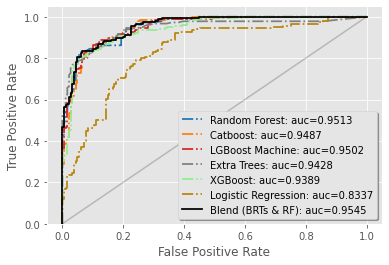

In [108]:
exec(open('ML_sdms_predict.py').read())

In [110]:
# blended (BRTs & RF) feature importance with validation set
feature_importances[len(feature_importances)-1]

Weight,Feature
0.0436 ± 0.0107,bclim8
0.0331 ± 0.0126,bclim6
0.0182 ± 0.0193,bclim15
0.0099 ± 0.0134,bclim12
0.0099 ± 0.0134,bclim11
0.0094 ± 0.0173,bclim4
0.0083 ± 0.0135,bclim2
0.0044 ± 0.0044,bclim7
0.0039 ± 0.0114,bclim14
0.0028 ± 0.0213,bclim18


### Geospatial Predictions of Species Distributions

---

We first perform spatial classification with the 5-model blended classifier. Spatial predictions were powered by the pyimpute library, see my [contributions](https://github.com/perrygeo/pyimpute/pull/21) merged at version 0.2 (_main.py). We also perform a spatial blend of the five models. In the next notebook, we perform a series of climate projections with 8 unique climate models over 16 different future scenarios. 

In [111]:
from pyimpute import load_training_vector
from pyimpute import load_targets
from pyimpute import impute

In [112]:
import glob 
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
# grab features, see Appendix section 1 below for feature selection methods
explanatory_rasters = ['bclim11', 'bclim12', 'bclim14', 'bclim15', 'bclim18',
               'bclim2', 'bclim3', 'bclim4', 'bclim6', 'bclim7', 'bclim8',
               'bclim9']
i = 0
for f in explanatory_rasters:
    explanatory_rasters[i] = ('data/train-rasters-2.5m/' + f + '.asc')
    i = (i + 1)
print('\nThere are', len(explanatory_rasters), '.asc features.') # check there are ten 
# grab shapefile containing 100% of the final presence/absence locations
response_data = gpd.GeoDataFrame.from_file('data/geofile-xv-presences/xv.shp') 
response_data.head(3) # check geopandas data 


There are 12 .asc features.


,CLASS,geometry
0,1.0,POINT (-118.42197 35.77997)
1,0.0,POINT (-117.35417 35.27083)
2,1.0,POINT (-118.60656 34.78263)


In [113]:
print("number of duplicates: ", response_data.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", response_data['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(response_data.crs))
print("{} observations with {} columns".format(*response_data.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: epsg:4326
1814 observations with 2 columns


In [114]:
# create pyimpute framework
train_xs, train_y = load_training_vector(response_data,
                                         explanatory_rasters,
                                         response_field='CLASS') 
train_xs.shape, train_y.shape # check shape

((1814, 12), (1814,))

In [115]:
# spatial prediction with the 5-model blended classifier
from sklearn import model_selection
import os
session_number = 'exp_id=101, xantusia_after'

target_xs, raster_info = load_targets(explanatory_rasters)
k = 5 
kf = model_selection.KFold(n_splits=k)
accuracy_scores = model_selection.cross_val_score(blender_specific, train_xs, train_y, cv=kf, scoring='accuracy')
print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
blender_specific.fit(train_xs, train_y)
# spatial prediction with impute function, saves tifs to file
os.mkdir('outputs' + session_number)
os.mkdir('outputs' + session_number + '/blender-baseline')
impute(target_xs, blender_specific, raster_info, outdir='outputs' + session_number + '/blender-baseline',
       class_prob=True, certainty=True)

Blend (BRTs & RF) 5-fold Cross Validation Accuracy: 86.49 (+/- 2.22)


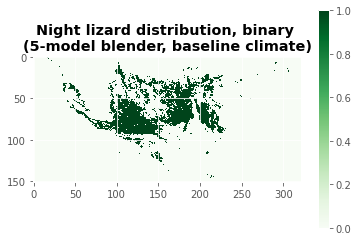

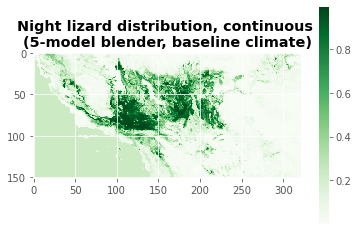

In [116]:
# plot the spatial output of the 5-model blended classifier
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')
blended_curr = rasterio.open('outputs'+ session_number + '/blender-baseline/responses.tif')
plotit(blended_curr.read(1),'Night lizard distribution, binary \n(5-model blender, baseline climate)',
        cmap='Greens')
plt.figure()
blended_curr = rasterio.open('outputs' + session_number + '/blender-baseline/probability_1.0.tif') 
plotit(blended_curr.read(1),'Night lizard distribution, continuous \n(5-model blender, baseline climate)',
       cmap='Greens')
print('')

In [117]:
# Now, compare the blended ensemble to the five individual classifiers
CLASS_MAP = {
    'rf': (rf),
    'et': (etrees),
    'xgb': (xgboost),
    'lgbm': (lgbm),
    'cb': (catboost)
    }
for name, (model) in CLASS_MAP.items():
    # Cross val for accuracy scores (as a %) for the entirety of the presence/background database
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    # spatial prediction
    model.fit(train_xs, train_y)
    os.mkdir('outputs' + session_number + '/' + name + '-baseline')
    impute(target_xs, model, raster_info, outdir='outputs' + session_number + '/' + name + '-baseline',
           class_prob=True, certainty=True)

rf 5-fold Cross Validation Accuracy: 86.66 (+/- 2.41)
et 5-fold Cross Validation Accuracy: 86.99 (+/- 1.94)
xgb 5-fold Cross Validation Accuracy: 85.67 (+/- 1.59)
lgbm 5-fold Cross Validation Accuracy: 86.44 (+/- 1.71)
cb 5-fold Cross Validation Accuracy: 86.33 (+/- 1.57)


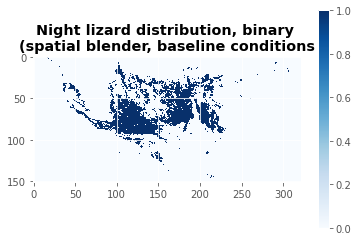

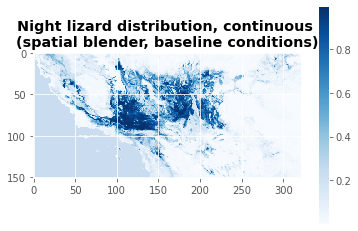

In [118]:
# import rasterio
distr_rf = rasterio.open(
    'outputs' + session_number + '/rf-baseline/probability_1.0.tif').read(1)
distr_et = rasterio.open('outputs' + session_number + '/et-baseline/probability_1.0.tif').read(1)
distr_xgb =  rasterio.open('outputs'+ session_number + '/xgb-baseline/probability_1.0.tif').read(1)
distr_lgbm =  rasterio.open('outputs'+ session_number + '/lgbm-baseline/probability_1.0.tif').read(1)
distr_cb =  rasterio.open('outputs'+ session_number + '/cb-baseline/probability_1.0.tif').read(1)
spatial_blend = (distr_rf + distr_et + distr_xgb + distr_lgbm + distr_cb)/5  

plotit(spatial_blend > 0.5, 'Night lizard distribution, binary \n(spatial blender, baseline conditions')
plt.figure()
plotit(spatial_blend, 'Night lizard distribution, continuous \n(spatial blender, baseline conditions)')
print('')

### Appendix 1: Removing Correlated Features
---

Recursively selects de-correlated features for modeling below a correlation threshold, such as Spearman's statistic, using the rank of feature importance scores from many classifiers.

---


In [120]:
exec(open('recursive-ranker.py').read())

In [121]:
# set up initial conditions for recursion function
# make absolute values of covariance matrix into upper triangular matrix with desired indexing
covariance = pd.read_csv('data/collinearity/xv-baseline.csv')
covariance.drop(['Unnamed: 0'], axis=1, inplace = True)
covariance_bool = covariance.isna() # designed to fail the first base case
covariancenp = pd.DataFrame.to_numpy(covariance)
covariancenp = np.triu(covariancenp)    
covariance = pd.DataFrame(covariancenp, columns = list(covariance))
for i in np.arange(0,len(covariance)):
    covariance.rename(index={i: list(covariance)[i]}, inplace = True)
covariance = covariance.abs()
feature_importance = pd.read_csv('maxent/maxent-jacknife.csv')
feature_importance.rename(index={0: 'importance'}, inplace = True)
feature_importance.sort_values(by='importance', axis=1, ascending=False)

,bclim6,bclim8,bclim11,bclim18,bclim1,bclim14,bclim9,bclim17,bclim10,bclim5,bclim15,bclim4,bclim7,bclim12,bclim3,bclim19,bclim13,bclim16,bclim2
importance,0.591,0.5659,0.5228,0.3416,0.3216,0.3191,0.2835,0.2803,0.2458,0.1822,0.1669,0.0937,0.081,0.072,0.0457,0.0456,0.0352,0.0334,0.0258


In [122]:
recursive_ranker(covariance, feature_importance, covariance_bool, 0.85, pd.read_csv('data/collinearity/raw_data.csv'))

Comparing bclim16 or bclim19
Dropping bclim16 

Comparing bclim13 or bclim19
Dropping bclim13 

Comparing bclim1 or bclim10
Dropping bclim10 

Comparing bclim14 or bclim17
Dropping bclim17 

Comparing bclim12 or bclim19
Dropping bclim19 

Comparing bclim1 or bclim5
Dropping bclim5 

Comparing bclim1 or bclim11
Dropping bclim1 

         bclim11   bclim12   bclim14   bclim15   bclim18    bclim2    bclim3  \
bclim11      1.0  0.360369  0.601673  0.153659  0.324422  0.154140  0.085145   
bclim12      0.0  1.000000  0.185364  0.517731  0.101761  0.309390  0.352861   
bclim14      0.0  0.000000  1.000000  0.632534  0.831020  0.360974  0.494897   
bclim15      0.0  0.000000  0.000000  1.000000  0.714014  0.021618  0.622199   
bclim18      0.0  0.000000  0.000000  0.000000  1.000000  0.413650  0.570669   
bclim2       0.0  0.000000  0.000000  0.000000  0.000000  1.000000  0.611145   
bclim3       0.0  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
bclim4       0.0  0.000000  0.

### Appendix 2 : MLFlow backend server
---

In [119]:
from pycaret.classification import get_logs
get_logs(experiment_name = 'xantusia')

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.F1,metrics.Prec.,metrics.Accuracy,metrics.TT,...,tags.mlflow.user,tags.URI,tags.USI,tags.mlflow.source.name,tags.Run Time,tags.mlflow.source.type,tags.Run ID,tags.mlflow.runName,tags.mlflow.log-model.history,tags.Source
0,4baffb6249b147589562002c33ca078a,1,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:35:46.366000+00:00,2020-11-08 02:35:46.467000+00:00,0.605400,0.689000,0.654800,0.014,...,danielfurman,332db2f6,a8e5,/opt/anaconda3/lib/python3.7/site-packages/ipy...,0.35,LOCAL,4baffb6249b147589562002c33ca078a,SVM - Linear Kernel,"[{""run_id"": ""4baffb6249b147589562002c33ca078a""...",compare_models
1,4d1cf51df7f14df7930332758bfd8204,1,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:35:46.138000+00:00,2020-11-08 02:35:46.229000+00:00,0.764800,0.773000,0.766800,0.008,...,danielfurman,332db2f6,a8e5,/opt/anaconda3/lib/python3.7/site-packages/ipy...,0.28,LOCAL,4d1cf51df7f14df7930332758bfd8204,Naive Bayes,"[{""run_id"": ""4d1cf51df7f14df7930332758bfd8204""...",compare_models
2,c2b965e6b6bb4b1f94c7f617ab6c36f9,1,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:35:45.900000+00:00,2020-11-08 02:35:45.994000+00:00,0.768000,0.774700,0.769800,0.010,...,danielfurman,332db2f6,a8e5,/opt/anaconda3/lib/python3.7/site-packages/ipy...,0.29,LOCAL,c2b965e6b6bb4b1f94c7f617ab6c36f9,Linear Discriminant Analysis,"[{""run_id"": ""c2b965e6b6bb4b1f94c7f617ab6c36f9""...",compare_models
3,df9aa7d92e2d48db815b54479844cdc5,1,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:35:45.669000+00:00,2020-11-08 02:35:45.765000+00:00,0.768000,0.774700,0.769800,0.008,...,danielfurman,332db2f6,a8e5,/opt/anaconda3/lib/python3.7/site-packages/ipy...,0.28,LOCAL,df9aa7d92e2d48db815b54479844cdc5,Ridge Classifier,"[{""run_id"": ""df9aa7d92e2d48db815b54479844cdc5""...",compare_models
4,2734a80ab9534b4489356d906f29a369,1,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:35:45.434000+00:00,2020-11-08 02:35:45.532000+00:00,0.771300,0.776400,0.772700,0.101,...,danielfurman,332db2f6,a8e5,/opt/anaconda3/lib/python3.7/site-packages/ipy...,1.21,LOCAL,2734a80ab9534b4489356d906f29a369,Logistic Regression,"[{""run_id"": ""2734a80ab9534b4489356d906f29a369""...",compare_models
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,a51ad090221d413797bc30d5239564a8,1,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-06 18:09:42.715000+00:00,2020-11-06 18:09:43.177000+00:00,0.836268,0.839614,0.836653,0.460,...,danielfurman,7d0131f4,ca00,/opt/anaconda3/lib/python3.7/site-packages/ipy...,3.88,LOCAL,a51ad090221d413797bc30d5239564a8,Random Forest Classifier,"[{""run_id"": ""a51ad090221d413797bc30d5239564a8""...",create_model
761,251f3f83a01a4a8eb7a78128080c2ef0,1,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-06 18:09:38.281000+00:00,2020-11-06 18:09:38.523000+00:00,0.842069,0.847120,0.842584,2.660,...,danielfurman,1a7cf3f4,ca00,/opt/anaconda3/lib/python3.7/site-packages/ipy...,24.02,LOCAL,251f3f83a01a4a8eb7a78128080c2ef0,CatBoost Classifier,"[{""run_id"": ""251f3f83a01a4a8eb7a78128080c2ef0""...",create_model
762,b31ef4c26fba441d8408a1673bddac51,1,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-06 18:09:13.677000+00:00,2020-11-06 18:09:13.956000+00:00,0.842204,0.845794,0.842574,0.270,...,danielfurman,46dc84f7,ca00,/opt/anaconda3/lib/python3.7/site-packages/ipy...,2.6,LOCAL,b31ef4c26fba441d8408a1673bddac51,Extreme Gradient Boosting,"[{""run_id"": ""b31ef4c26fba441d8408a1673bddac51""...",create_model
763,2eca406a52c049778eea2dd50bab5de0,1,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-06 18:09:10.296000+00:00,2020-11-06 18:09:10.793000+00:00,0.846123,0.850070,0.846525,0.480,...,danielfurman,43cbc9c6,ca00,/opt/anaconda3/lib/python3.7/site-packages/ipy...,3.6,LOCAL,2eca406a52c049778eea2dd50bab5de0,Extr